# Basic ML Models of the Kaggle House Price Dataset

In [1]:
import pandas as pd
print("pandas version: {}". format(pd.__version__))

# numpy: support for large, multi-dimensional arrays and matrices and high-level mathematical functions
import numpy as np
print("numpy version: {}". format(np.__version__))

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, BayesianRidge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score, learning_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
print("sklearn version: {}". format(sklearn.__version__))

import optuna
print("optuna version: {}". format(optuna.__version__))

import mlflow
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID
from mlflow.tracking import MlflowClient
print("mlflow version: {}". format(mlflow.__version__))

import matplotlib.pyplot as plt
import seaborn as sns

import os
from datetime import datetime
from typing import Optional
import warnings
warnings.simplefilter('ignore')

import yaml
with open('ml_parameter.yaml') as file:
  config_data= yaml.safe_load(file)


from create_algorithm import create_algorithm
import pipeline_classes

pandas version: 1.5.3
numpy version: 1.23.5
sklearn version: 1.2.2


e:\programs\anaconda3\envs\mlflow_optuna\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


optuna version: 2.10.1
mlflow version: 2.1.1


In [2]:
VERSION = "1"
SCRIPT = "test"

# VERSION = 0.6
# SCRIPT = "houseprices_BasicModels_pipeline"

mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient()
try:
    experiment = client.create_experiment(f"{SCRIPT}_{VERSION}")
except:
    experiment = client.get_experiment_by_name(f"{SCRIPT}_{VERSION}").experiment_id

In [3]:
def StratifiedKFold_Regression(df, target, bins, n_splits):
    from sklearn.model_selection import StratifiedKFold

    df['Fold'] = -1
    skf = StratifiedKFold(n_splits=n_splits)

    y_cat = pd.cut(df[target], bins, labels=False)

    for fold_no, (t, v) in enumerate(skf.split(y_cat, y_cat)):
        df.loc[v, 'Fold'] = fold_no

    sns.histplot(data=df, x=y_cat, hue="Fold", multiple="stack")

    return df

In [4]:
def find_season(month, hemisphere):
    if hemisphere == 'Southern':
        season_month_south = {
            12:'Summer', 1:'Summer', 2:'Summer',
            3:'Autumn', 4:'Autumn', 5:'Autumn',
            6:'Winter', 7:'Winter', 8:'Winter',
            9:'Spring', 10:'Spring', 11:'Spring'}
        return season_month_south.get(month)
        
    elif hemisphere == 'Northern':
        season_month_north = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Autumn', 10:'Autumn', 11:'Autumn'}
        return season_month_north.get(month)
    else:
        print('Invalid selection. Please select a hemisphere and try again')


class CreateNewFeatures(BaseEstimator, TransformerMixin):

    def __init__(self):
        return None

    def fit(self, x:pd.DataFrame, y:Optional[pd.DataFrame]=None) -> "CreateNewFeatures":
        return self

    def transform(self, x:pd.DataFrame) -> pd.DataFrame:
        print(x.shape)
        x["TotalFS"] = x["1stFlrSF"] + x["2ndFlrSF"] + x["GrLivArea"]
        x["MeanSFRoom"] = round(x["TotalFS"] / x["TotRmsAbvGrd"], 0)
        x["YearsBeforeWork"] = x["YearRemodAdd"] - x["YearBuilt"]
        x["TotalBath"] = x["FullBath"] + 0.5*x["HalfBath"] + x["BsmtFullBath"] + 0.5*x["BsmtHalfBath"]
        x["TotalFS_TotalBath"] = x["TotalFS"] / x["TotalBath"]
        x["GarageArea_GarageCars"] = x["GarageArea"] / x["GarageCars"]
        x["TotalPorchSF"] = x["OpenPorchSF"] + x["EnclosedPorch"] + x["3SsnPorch"] + x["ScreenPorch"]
        x["YearsBeforeSold"] = x["YrSold"] - x["YearBuilt"]
        x["SeasonSold"] = x["MoSold"].apply(lambda x: find_season(x, "Northern"))

        x['PoolArea_bin'] = x['PoolArea'].apply(lambda x: 1 if x>0 else 0)
        x['TotalPorchSF_bin'] = x['TotalPorchSF'].apply(lambda x: 1 if x>0 else 0)
        x['GarageArea_bin'] = x['GarageArea'].apply(lambda x: 1 if x>0 else 0)
        x['MiscVal_bin'] = x['MiscVal'].apply(lambda x: 1 if x>0 else 0)

        # transform month to continous feature
        x['MoSold'] = (-np.cos(0.5236*x['MoSold']))

        x.replace([np.inf, -np.inf], 0, inplace=True)
        print(x.shape)
        return x

(1460, 75)
(1460, 88)
(1459, 74)
(1459, 87)


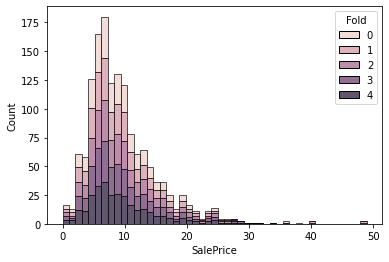

In [5]:
def load_data():
    # load raw training and test dataset
    df_train = pd.read_csv("../01_RawData/train.csv")
    df_test = pd.read_csv("../01_RawData/test.csv")

    # drop features with more then 30% of missing values
    df_train = df_train.drop(["Id", "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], axis=1)
    df_test = df_test.drop(["Id", "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], axis=1)

    feature_transformer = CreateNewFeatures()
    feature_transformer.fit(df_train)
    df_train = feature_transformer.transform(df_train)
    df_test = feature_transformer.transform(df_test)

    # compute StratifiedKFold column
    df_train = StratifiedKFold_Regression(df_train, "SalePrice", 50, 5)

    # split the training and test dataset to the input features (x_train, x_test) and the survival class (y_train)
    y_train = df_train['SalePrice']
    x_train = df_train.drop(['SalePrice'], axis=1)
    x_test = df_test

    x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    return x_train, y_train, x_validate, y_validate, x_test

x_train, y_train, x_validate, y_validate, x_test = load_data()

In [6]:
def get_feature_classes(x_train):
    # numeric features
    numeric_features = x_train.select_dtypes([np.number]).columns.to_list()
    numeric_features.remove("Fold")

    # ordinal_features
    ordinal_features = [
        "Utilities",
        "LandSlope",
        "HouseStyle",
        "ExterQual",
        "ExterCond",
        "BsmtQual",
        "BsmtCond",
        "GarageQual",
        "GarageCond",
        "BsmtExposure",
        "BsmtFinType1",
        "BsmtFinType2",
        "HeatingQC",
        "KitchenQual",
        "Functional",
        "GarageFinish",
        "PavedDrive",
        "SeasonSold"
        ]
    
    category_features = x_train.select_dtypes(['object', 'category'])

    # categorical features with high cardinality
    category_features_high_cardinality = category_features.columns[category_features.nunique() >50].tolist()
    category_features_high_cardinality = list(set(category_features_high_cardinality) - set(ordinal_features))
    
    # categorical features with low cardinality
    category_features_low_cardinality = category_features.columns[category_features.nunique() <=50].tolist()
    category_features_low_cardinality = list(set(category_features_low_cardinality) - set(ordinal_features))

    return numeric_features, ordinal_features, category_features_high_cardinality, category_features_low_cardinality

numeric_features, ordinal_features, category_features_high_cardinality, category_features_low_cardinality = get_feature_classes(x_train)

In [7]:
# define cross validation

# cv = ShuffleSplit(
#     n_splits = 10,
#     test_size = 0.2,
#     random_state = 42
#     )

from sklearn.model_selection import GroupKFold
cv = GroupKFold(n_splits=5)

In [8]:
def create_model(self, trial):

    child_run = client.create_run(
        experiment_id=experiment,
        tags={
            MLFLOW_PARENT_RUN_ID: self.parent_run.info.run_id
        }
    )

    model = create_algorithm(self.model_type, trial, client, child_run, config_data)

    # create parameter for data preprocessing pipeline
    imputer_function_numeric=trial.suggest_categorical("preprocessing_imputer_function_numeric", ["SimpleImputer", "KNNImputer"])
    skewed_threshold=trial.suggest_float("preprocessing_skewed_threshold", 0.5, 2, log=False)
    ohe_min_frequency=trial.suggest_float("preprocessing_ohe_min_frequency", 0, 0.2, log=False)
    ohe_max_categories=trial.suggest_int('preprocessing_ohe_max_categories', 5, 20)
    feature_selection_low_variance_flag=trial.suggest_float("preprocessing_feature_selection_low_variance_flag", 0.7, 0.99, log=False)
    correlation=trial.suggest_float("preprocessing_correlation", 0.7, 0.99, log=False)
    scaler = trial.suggest_categorical("columnprep__transformers_num", ["StandardScaler", "MinMaxScaler"])
    pca_n_components = trial.suggest_float('pca_n_components', 0, 1)

    # log all parameters of the data preprocessing with mlflow
    client.log_param(child_run.info.run_id, "preprocessing_imputer_function_numeric", imputer_function_numeric)
    client.log_param(child_run.info.run_id, "preprocessing_skewed_threshold", skewed_threshold)
    client.log_param(child_run.info.run_id, "preprocessing_ohe_min_frequency", ohe_min_frequency)
    client.log_param(child_run.info.run_id, "preprocessing_ohe_max_categories", ohe_max_categories)
    client.log_param(child_run.info.run_id, "preprocessing_feature_selection_low_variance_flag", feature_selection_low_variance_flag)
    client.log_param(child_run.info.run_id, "preprocessing_correlation", correlation)
    client.log_param(child_run.info.run_id, "preprocessing_scaler", scaler)  
    client.log_param(child_run.info.run_id, "pca_n_components", pca_n_components)


    # build numeric part of the pipeline
    numeric_transformer = Pipeline(steps=[
        ("imputer", pipeline_classes.ImputMissingValuesNumeric(imputer_function=imputer_function_numeric)),
        ("skew", pipeline_classes.SkewedFeatureTransformer(skewed_threshold=skewed_threshold)),
        ("scaler", pipeline_classes.ScalerTransformer(columnprep__transformers_num=scaler))
        ])

    # build categoric part of the pipeline
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
            ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop="if_binary"))
        ]
    )

    # build ordinal part of the pipeline
    ordinal_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
            ("encoder", OrdinalEncoder(categories=[
                ["ELO", "NoSeWa", "NoSewr", "AllPub"],
                ["Gtl", "Mod", "Sev"],
                ["1Story", "1.5Fin", "1.5Unf", "2Story", "2.5Fin", "2.5Unf", "SFoyer", "SLvl"],
                ["Po", "Fa", "TA", "Gd", "Ex"],
                ["Po", "Fa", "TA", "Gd", "Ex"],
                ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
                ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
                ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
                ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
                ["NA", "No", "Mn", "Av", "Gd"],
                ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
                ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
                ["Po", "Fa", "TA", "Gd", "Ex"],
                ["Po", "Fa", "TA", "Gd", "Ex"],
                ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
                ["NA", "Unf", "RFn", "Fin"],
                ["Y", "P", "N"],
                ["Winter", "Spring", "Summer", "Autumn"]
                ])
            )
        ]
    )


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, category_features_low_cardinality),
            ("ord", ordinal_transformer, ordinal_features)
        ], remainder='drop'
    )

    feature_selection = Pipeline(
        steps=[
        ("variance", VarianceThreshold()),
        ("correlation", pipeline_classes.CorrelationTransformer(correlation_threshold=correlation)),
        ("PCA", PCA(n_components=pca_n_components)),
        ]
    )

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("feature_selection", feature_selection),
        ("regressor", model)
        ]
    )




    # pipeline = make_pipeline(
    #         pipeline_classes.ImputMissingValuesNumeric(imputer_function=imputer_function_numeric),
    #         pipeline_classes.ImputMissingValuesCategoric(),
    #         pipeline_classes.CreateNewFeatures(),
    #         pipeline_classes.ImputMissingValuesNumeric(imputer_function=imputer_function_numeric),
    #         pipeline_classes.SkewedFeatureTransformer(transform_skewed_features_flag=transform_skewed_features_flag),
    #         pipeline_classes.LabelEncoderTransformer(),
    #         pipeline_classes.OneHotEncoderTransformer(ohe_min_frequency=ohe_min_frequency, ohe_max_categories=ohe_max_categories),
    #         pipeline_classes.LowVarianceTransformer(variance_threshold=feature_selection_low_variance_flag),
    #         pipeline_classes.CorrelationTransformer(correlation_threshold=correlation),
    #         pipeline_classes.ScalerTransformer(columnprep__transformers_num=scaler),
    #         PCA(n_components=pca_n_components),
    #         model
    # )

    return pipeline, child_run

In [9]:
def create_submission(best_model, x_test, parent_run, study):
    # check if folder exists
    if not os.path.exists(f'submissions/{SCRIPT}/{VERSION}'):
        os.makedirs(f'submissions/{SCRIPT}/{VERSION}')
    
    # predict the test values with the training classification model
    y_pred = best_model.predict(x_test)
    
    df_submission = pd.read_csv("../01_RawData/sample_submission.csv")
    df_submission.iloc[:, 1] = y_pred
    
    df_submission.to_csv(f'submissions/{SCRIPT}/{VERSION}/{parent_run.info.run_id}.csv', index=False)

In [10]:
def evaluate_model(x_train, y_train, y_validate, y_validate_pred, pipeline, parent_run):

    def plot_learning_curve(pipeline, x_train, y_train, cv=cv, train_sizes=np.linspace(.1, 1.0, 50)):
        train_sizes, train_scores, test_scores = learning_curve(
            pipeline,
            x_train,
            y_train,
            cv=cv,
            n_jobs=-1,
            groups=x_train["Fold"],
            train_sizes=np.linspace(.1, 1.0, 8)
            )


        fig1, ax1 = plt.subplots()
        ax1.set_xlabel("Training examples")
        ax1.set_ylabel("Score")
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax1.grid()

        ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
        ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax1.plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training score")
        ax1.plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation score")

        ax1.legend(loc="best")
        ax1.set_title("Difference between training and CV: "\
            + str(round(test_scores_mean[7] / train_scores_mean[7] * 100, 2))\
            + "%")
        client.log_figure(parent_run.info.run_id, fig1, 'plot_learning_curve.png')
        plt.close()

    plot_learning_curve(pipeline, x_train, y_train)


    def plot_scatter(y_true, y_pred):
        fig2, ax2 = plt.subplots()
        ax2.scatter(y_pred, y_true.values)
        ax2.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], c="red")
        ax2.set_ylabel("True Values")
        ax2.set_xlabel("Predicted Values")
        client.log_figure(parent_run.info.run_id, fig2, 'plot_regression.png')
        plt.close()

    plot_scatter(y_validate, y_validate_pred)

In [11]:
class Objective:
    
    def __init__(self, model_type, parent_run):
        self.best_model = None
        self._model = None
        self.model_type = model_type
        self.parent_run = parent_run

    
    def __call__(self, trial):
    
        pipeline, child_run = create_model(self, trial)
        self._model = pipeline

        cvs = np.sqrt(
            -cross_val_score(
                pipeline,
                x_train.drop(columns=["Fold"]), y_train,
                cv=cv,
                groups=x_train["Fold"],
                scoring="neg_mean_squared_error",
                n_jobs=1
                )
            )

        rmse = cvs.mean()
        rmse_var = np.var(cvs)

        client.log_metric(child_run.info.run_id, "cv_rmse", rmse)
        client.log_metric(child_run.info.run_id, "cv_var", rmse_var)
        
        return rmse

    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model

In [12]:
# model_type='Lasso'
model_type='Ridge'
# model_type='BayesianRidge'
# model_type='ElasticNet'
# model_type='GradientBoostingRegressor'
# model_type='RandomForestRegressor'






parent_run = client.create_run(
    experiment_id=experiment, 
    tags={"script_name": SCRIPT, "script_version": VERSION}
    )

objective = Objective(model_type, parent_run)

study = optuna.create_study(direction="minimize")

study.optimize(
    objective,
    n_trials=config_data["N_TRAILS"],
    timeout=config_data["TIMEOUT"],
    callbacks=[objective.callback]
    )

print("Best trial:")
print(study.best_value)
print(study.best_params)

print("Log CV Params")
client.log_metric(parent_run.info.run_id, "best_cv_score", round(study.best_value, 3))
# client.log_param(parent_run.info.run_id, "transformer_num", str(transformer_num))

# client.log_param(parent_run.info.run_id, "cv_n_splits", cv.n_splits)
# client.log_param(parent_run.info.run_id, "cv_train_size", cv.train_size)
# client.log_param(parent_run.info.run_id, "cv_test_size", cv.test_size)
# client.log_param(parent_run.info.run_id, "cv_random_state", cv.random_state)

for param in study.best_params:
    client.log_param(parent_run.info.run_id, param, study.best_params[param])

best_model = objective.best_model
client.log_param(parent_run.info.run_id, "algo", best_model.get_params()["steps"][-1][1].__class__.__name__)


# fit the pipeline to compute the validation results
print("Fit Best Model")
best_model.fit(x_train.drop(columns=["Fold"]), y_train)

# predict the training outcome
print("Predict Best Model")
y_validate_pred = best_model.predict(x_validate)

# evaluate model
print("Evaluate Best Model")
client.log_metric(parent_run.info.run_id, "r2", r2_score(y_validate, y_validate_pred))
evaluate_model(x_train, y_train, y_validate, y_validate_pred, best_model, parent_run)

# # create submission of best model
print("Create submission")
create_submission(best_model, x_test, parent_run, study)

mlflow.end_run()

[I 2023-04-21 18:22:26,350] A new study created in memory with name: no-name-378148e0-e732-4dfe-9023-7b05985c9a87
[I 2023-04-21 18:22:29,149] Trial 0 finished with value: 35104.2320347825 and parameters: {'ridge_alpha': 4.595351011432763, 'ridge_max_iter': 815, 'ridge_solver': 'cholesky', 'preprocessing_imputer_function_numeric': 'KNNImputer', 'preprocessing_skewed_threshold': 0.7259280450569768, 'preprocessing_ohe_min_frequency': 0.021184101964361803, 'preprocessing_ohe_max_categories': 19, 'preprocessing_feature_selection_low_variance_flag': 0.7599878025645379, 'preprocessing_correlation': 0.8611916153287013, 'columnprep__transformers_num': 'StandardScaler', 'pca_n_components': 0.9192592903247142}. Best is trial 0 with value: 35104.2320347825.
[I 2023-04-21 18:22:31,574] Trial 1 finished with value: 75521.56958910145 and parameters: {'ridge_alpha': 3.4412487927930817, 'ridge_max_iter': 590, 'ridge_solver': 'cholesky', 'preprocessing_imputer_function_numeric': 'SimpleImputer', 'prepro

Best trial:
32724.63789235634
{'ridge_alpha': 5.722206706635747, 'ridge_max_iter': 414, 'ridge_solver': 'cholesky', 'preprocessing_imputer_function_numeric': 'SimpleImputer', 'preprocessing_skewed_threshold': 1.9203027037835605, 'preprocessing_ohe_min_frequency': 0.1272578263218804, 'preprocessing_ohe_max_categories': 13, 'preprocessing_feature_selection_low_variance_flag': 0.9895597874008063, 'preprocessing_correlation': 0.9698011427768659, 'columnprep__transformers_num': 'MinMaxScaler', 'pca_n_components': 0.9966744212764737}
Log CV Params
Fit Best Model
Predict Best Model
Evaluate Best Model
Create submission


In [13]:
mlflow.end_run()